Import Statements

In [1]:
import numpy as np  
import pandas as pd  
from pandas_datareader import data as wb  
import matplotlib.pyplot as plt  
from scipy.stats import norm
%matplotlib inline

Get the past 10 years of stock price close data for Proctor & Gamble

In [2]:
ticker = 'PG' 
data = pd.DataFrame()
data[ticker] = wb.DataReader(ticker, data_source='yahoo', start='2010-1-1')['Adj Close']

Estimate historical log returns

In [3]:
log_returns = np.log(1 + data.pct_change())
log_returns.tail()

,PG
Date,
2020-07-31,-0.002285
2020-08-03,0.001296
2020-08-04,0.018863
2020-08-05,-0.002619
2020-08-06,-0.005486


Plot PG's price

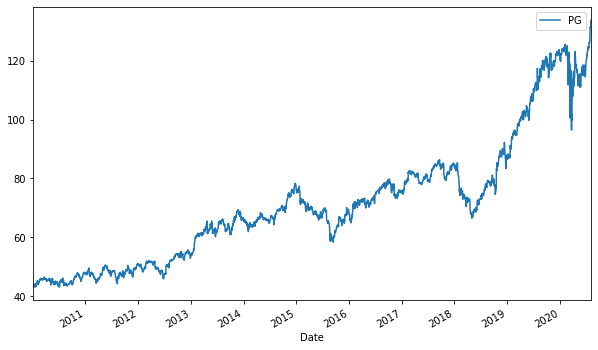

In [4]:
data.plot(figsize=(10, 6));

Plot log returns

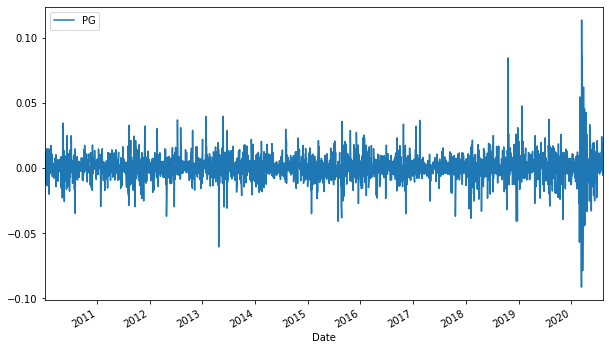

In [5]:
log_returns.plot(figsize = (10, 6))

find the mean

In [6]:
u = log_returns.mean()
u

PG    0.000416
dtype: float64

find the variance

In [7]:
var = log_returns.var()
var

PG    0.000118
dtype: float64

calculate the drift component for our geometric brownian motion model, mean - 1/2 variance

In [8]:
drift = u - (0.5 * var)
drift

PG    0.000357
dtype: float64

stddev of returns

In [9]:
stdev = log_returns.std()
stdev

PG    0.010861
dtype: float64

check that the types of our variables are pandas series

In [10]:
type(drift)

pandas.core.series.Series

In [11]:
type(stdev)

pandas.core.series.Series

convert pandas to np arrays

In [12]:
np.array(drift)

array([0.00035701])

In [13]:
drift.values

array([0.00035701])

works with stddev too

In [14]:
stdev.values

array([0.01086058])

function to find standard deviation of percent chance, for instance 95% chance (lower tail probability) is 1.65 standard deviations above the mean

In [15]:
norm.ppf(0.95)

1.6448536269514722

10x2 array of random numbers

In [16]:
x = np.random.rand(10, 2)
x

array([[7.92602509e-01, 2.99115755e-01],
       [9.33606642e-02, 7.86054605e-01],
       [8.27709961e-01, 8.64325643e-02],
       [3.15591160e-02, 8.84478365e-01],
       [7.89499177e-01, 9.64130446e-01],
       [3.36319815e-01, 8.31130996e-01],
       [4.03984555e-01, 9.14214712e-01],
       [5.01349337e-04, 8.42967548e-01],
       [9.60999108e-01, 3.07463586e-01],
       [2.56604978e-01, 2.16654499e-02]])

pass the random numbers into the ppf function

In [17]:
norm.ppf(x)

array([[ 0.81548459, -0.52694539],
       [-1.32034059,  0.79280612],
       [ 0.94515436, -1.36305516],
       [-1.85835772,  1.19767576],
       [ 0.80468471,  1.8007702 ],
       [-0.42252805,  0.95864422],
       [-0.24304684,  1.36717463],
       [-3.28976843,  1.00672924],
       [ 1.76239973, -0.50305277],
       [-0.65384766, -2.02050628]])

call this a random variable denoted $Z$

In [18]:
Z = norm.ppf(np.random.rand(10,2))
Z

array([[-0.40819359,  0.66658715],
       [ 0.01348871, -0.48209387],
       [ 0.00406163,  0.3592137 ],
       [ 1.13104908, -0.9622145 ],
       [-0.69239099, -0.95889304],
       [ 0.58789317, -1.14330021],
       [ 2.02606883,  0.8296132 ],
       [ 1.68564032,  0.74885111],
       [-1.23018634,  0.3222006 ],
       [-0.07762224,  0.56286307]])

variables for the simulation

`t_intervals` is the number of days in the future

`iterations` is the number of times to simulate

In [19]:
t_intervals = 60
iterations = 10

matrix of daily returns = $e^{\text{drift} + \text{stddev} \cdot Z}$

In [20]:
daily_returns = np.exp(drift.values + stdev.values * norm.ppf(np.random.rand(t_intervals, iterations)))
daily_returns

array([[0.99910401, 1.03048371, 0.98798602, 1.00466256, 0.9952595 ,
        1.00547997, 0.98327974, 1.00872259, 0.97689063, 0.99715245],
       [1.00185077, 0.99782797, 0.99377385, 1.00595208, 0.98333463,
        0.99664574, 0.98902879, 0.98099608, 1.01602582, 0.99400013],
       [0.99403544, 0.98436506, 0.98528982, 0.99824242, 1.00975628,
        1.00404066, 0.99627043, 1.01149569, 1.00314214, 0.98763206],
       [0.98004872, 0.97588438, 1.01250327, 1.00678138, 0.98645762,
        1.00029482, 1.00987202, 0.99745101, 1.01994463, 1.01147258],
       [0.99939064, 1.00516487, 0.99574058, 0.99964575, 0.99866312,
        1.01353311, 0.99220148, 1.00427578, 0.97120688, 0.9955762 ],
       [1.00636981, 0.99173973, 0.97813713, 0.99845175, 0.99788447,
        0.99707011, 1.00935188, 1.00062124, 0.99822398, 0.99607587],
       [1.00785257, 1.00289084, 0.99849372, 0.99649113, 1.00704821,
        1.00192628, 1.00692002, 1.00472735, 1.01257572, 1.0138368 ],
       [1.0099337 , 1.01177776, 0.9987498

Each row represents a day, each column represents a simulation. The values are the daily returns for that day and simulation. $S_{t+1} = S_{t-1} \cdot r$. We set $S_0$ equal to the current stock price.

In [21]:
S0 = data.iloc[-1]
S0

PG    132.710007
Name: 2020-08-06 00:00:00, dtype: float64

create a new array with the same dimentions as `daily returns`

In [22]:
price_list = np.zeros_like(daily_returns)
price_list

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 

set the first row (first day) of the simulation equal to the current price

In [23]:
price_list[0] = S0
price_list

array([[132.71000671, 132.71000671, 132.71000671, 132.71000671,
        132.71000671, 132.71000671, 132.71000671, 132.71000671,
        132.71000671, 132.71000671],
       [  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ],
       [  

simulate each day

In [25]:
for t in range(1, t_intervals):
    price_list[t] = price_list[t - 1] * daily_returns[t]

did it work?

In [26]:
price_list

array([[132.71000671, 132.71000671, 132.71000671, 132.71000671,
        132.71000671, 132.71000671, 132.71000671, 132.71000671,
        132.71000671, 132.71000671],
       [132.95562267, 132.42175721, 131.88373409, 133.49990795,
        130.49834512, 132.26486326, 131.25401719, 130.18799581,
        134.83679388, 131.91376362],
       [132.16260092, 130.35135128, 129.94370087, 133.26527055,
        131.77152366, 132.79930064, 130.76449669, 131.68459638,
        135.26047062, 130.28226251],
       [129.52578723, 127.20784703, 131.56842243, 134.16899317,
        129.98702311, 132.838453  , 132.05540634, 131.34893419,
        137.95819108, 131.7769365 ],
       [129.44685916, 127.86485895, 131.00801708, 134.12146339,
        129.81324545, 134.63617061, 131.02556994, 131.91055387,
        133.98594439, 131.19398125],
       [130.27141121, 126.8086603 , 128.14380606, 133.91381048,
        129.53862154, 134.24170172, 132.25090519, 131.9925018 ,
        133.74798258, 130.67915896],
       [13